In [19]:
import pandas as pd 
import numpy as np 
import xgboost as xgb
from model_utils import tune_model, pre_process_for_ML, eval_model, get_feature_importance 

# Import Cleaned Data

In [2]:
df = pd.read_csv("../../data/cleaned_data/2023_cleaned_ML_data.csv")
df.head()

,name,position,team,GW,minutes,goals_scored,assists,clean_sheets,saves,penalties_saved,...,yellow_cards,red_cards,own_goals,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,team_standing,sched_strength,5_gw_fpl_pts
0,Aaron Cresswell,DEF,West Ham,5,86.2,0.0,0.0,0.2,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,17.0,13.250000,2.25
1,Aaron Hickey,DEF,Brentford,5,77.8,0.0,0.0,0.2,0.0,0.0,...,0.4,0.0,0.0,0.0,0.0,0.0,0.0,8.2,9.000000,1.00
2,Aaron Ramsdale,GK,Arsenal,5,90.0,0.0,0.0,0.4,1.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,6.250000,2.75
3,Aaron Wan-Bissaka,DEF,Man Utd,5,0.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,6.666667,0.00
4,Abdoulaye Doucouré,MID,Everton,5,24.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,8.500000,0.50


## Split data by FWD, MID, DEF, and GK for separate models 

In [3]:
df_fwd = df[df["position"] == "FWD"]
df_mid = df[df["position"] == "MID"]
df_def = df[df["position"] == "DEF"] 
df_gk = df[df["position"] == "GK"] 

In [4]:
print(f"df_fwd size: {len(df_fwd)}")
print(f"df_mid size: {len(df_mid)}")
print(f"df_def size: {len(df_def)}")
print(f"df_gk size: {len(df_gk)}")

df_fwd size: 2741
df_mid size: 9993
df_def size: 7999
df_gk size: 2446


# FWD Model

## Tuning 

In [5]:
best_trial = tune_model(df_fwd, 200)
best_trial

[I 2023-08-12 22:59:29,955] A new study created in memory with name: no-name-214980ee-f40f-4e1b-8b89-5838e0e80ac4
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2023-08-12 22:59:30,438] Trial 0 finished with value: 0.6070567373438519 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.027459616698396562, 'subsample': 0.9520364306166089, 'colsample_bytree': 0.7266073423465997, 'gamma': 1.2324579421685362, 'reg_alpha': 4.861212829742701, 'reg_lambda': 3.679454322297814}. Best is trial 0 with value: 0.6070567373438519.
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with t

FrozenTrial(number=179, state=TrialState.COMPLETE, values=[0.6719373074024395], datetime_start=datetime.datetime(2023, 8, 12, 23, 2, 45, 105292), datetime_complete=datetime.datetime(2023, 8, 12, 23, 2, 46, 226236), params={'n_estimators': 859, 'max_depth': 7, 'learning_rate': 0.05559001763578621, 'subsample': 0.6741339853791233, 'colsample_bytree': 0.6453475157096956, 'gamma': 0.11968184698519965, 'reg_alpha': 1.7001430046267285, 'reg_lambda': 4.731693636525513}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_alpha': FloatDistr

In [7]:
# optimised params
best_trial.params

{'n_estimators': 859,
 'max_depth': 7,
 'learning_rate': 0.05559001763578621,
 'subsample': 0.6741339853791233,
 'colsample_bytree': 0.6453475157096956,
 'gamma': 0.11968184698519965,
 'reg_alpha': 1.7001430046267285,
 'reg_lambda': 4.731693636525513}

## Create FWD Model

In [40]:
fwd_params = {
    'n_estimators': 859,
    'max_depth': 7,
    'learning_rate': 0.05559001763578621,
    'subsample': 0.6741339853791233,
    'colsample_bytree': 0.6453475157096956,
    'gamma': 0.11968184698519965,
    'reg_alpha': 1.7001430046267285,
    'reg_lambda': 4.731693636525513
    }

X_train_fwd, X_test_fwd, y_train_fwd, y_test_fwd = pre_process_for_ML(df_fwd)

fwd_model = xgb.XGBRegressor(**fwd_params, random_state=42)
fwd_model.fit(X_train_fwd, y_train_fwd)

/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6453475157096956,
             enable_categorical=False, gamma=0.11968184698519965, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05559001763578621, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=859, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=1.7001430046267285,
             reg_lambda=4.731693636525513, scale_pos_weight=1,
             subsample=0.6741339853791233, tree_method='exact',
             validate_parameters=1, verbosity=None)

# MID Model

## Tuning

In [23]:
best_trial = tune_model(df_mid, 200)
best_trial

[I 2023-08-12 23:13:48,754] A new study created in memory with name: no-name-1b632acc-e55d-41a0-8a0f-a7453372e473
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2023-08-12 23:13:51,025] Trial 0 finished with value: 0.6196606752508236 and parameters: {'n_estimators': 525, 'max_depth': 9, 'learning_rate': 0.09469979075047191, 'subsample': 0.8657584772010299, 'colsample_bytree': 0.6540297249427115, 'gamma': 1.004705862229705, 'reg_alpha': 4.109595788017525, 'reg_lambda': 0.9709783698001062}. Best is trial 0 with value: 0.6196606752508236.
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with th

FrozenTrial(number=199, state=TrialState.COMPLETE, values=[0.6419628890168816], datetime_start=datetime.datetime(2023, 8, 12, 23, 28, 23, 452828), datetime_complete=datetime.datetime(2023, 8, 12, 23, 28, 29, 559971), params={'n_estimators': 979, 'max_depth': 10, 'learning_rate': 0.04966552828854492, 'subsample': 0.9548950024052398, 'colsample_bytree': 0.8769834852122966, 'gamma': 0.011777268607115216, 'reg_alpha': 3.021234581264507, 'reg_lambda': 0.9721161969773635}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_alpha': FloatD

In [24]:
best_trial.params

{'n_estimators': 979,
 'max_depth': 10,
 'learning_rate': 0.04966552828854492,
 'subsample': 0.9548950024052398,
 'colsample_bytree': 0.8769834852122966,
 'gamma': 0.011777268607115216,
 'reg_alpha': 3.021234581264507,
 'reg_lambda': 0.9721161969773635}

## Create MID Model 

In [29]:
mid_params = {
    'n_estimators': 979,
    'max_depth': 10,
    'learning_rate': 0.04966552828854492,
    'subsample': 0.9548950024052398,
    'colsample_bytree': 0.8769834852122966,
    'gamma': 0.011777268607115216,
    'reg_alpha': 3.021234581264507,
    'reg_lambda': 0.9721161969773635
}

X_train_mid, X_test_mid, y_train_mid, y_test_mid = pre_process_for_ML(df_mid)

mid_model = xgb.XGBRegressor(**mid_params, random_state=42)
mid_model.fit(X_train_mid, y_train_mid)

/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8769834852122966,
             enable_categorical=False, gamma=0.011777268607115216, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.04966552828854492, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=979, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=3.021234581264507,
             reg_lambda=0.9721161969773635, scale_pos_weight=1,
             subsample=0.9548950024052398, tree_method='exact',
             validate_parameters=1, verbosity=None)

# DEF Model

## Tuning

In [27]:
best_trial = tune_model(df_def, 200)
best_trial

[I 2023-08-12 23:30:53,308] A new study created in memory with name: no-name-13a2e678-bf33-4505-b917-d3cd229e76f0
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2023-08-12 23:30:56,274] Trial 0 finished with value: 0.5464533094906037 and parameters: {'n_estimators': 714, 'max_depth': 9, 'learning_rate': 0.008522615365442203, 'subsample': 0.9914327684495543, 'colsample_bytree': 0.6931070309874703, 'gamma': 3.7659444988423503, 'reg_alpha': 2.0570041815931988, 'reg_lambda': 4.091783666165628}. Best is trial 0 with value: 0.5464533094906037.
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with 

FrozenTrial(number=129, state=TrialState.COMPLETE, values=[0.6087616130088257], datetime_start=datetime.datetime(2023, 8, 12, 23, 35, 35, 568544), datetime_complete=datetime.datetime(2023, 8, 12, 23, 35, 36, 876565), params={'n_estimators': 404, 'max_depth': 7, 'learning_rate': 0.06170348483302929, 'subsample': 0.5391861928518548, 'colsample_bytree': 0.7604814430727136, 'gamma': 0.3998952703083139, 'reg_alpha': 0.613882120293917, 'reg_lambda': 0.19612957743165443}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_alpha': FloatDis

In [30]:
best_trial.params

{'n_estimators': 404,
 'max_depth': 7,
 'learning_rate': 0.06170348483302929,
 'subsample': 0.5391861928518548,
 'colsample_bytree': 0.7604814430727136,
 'gamma': 0.3998952703083139,
 'reg_alpha': 0.613882120293917,
 'reg_lambda': 0.19612957743165443}

## Create DEF Model

In [31]:
def_params = {
    'n_estimators': 404,
    'max_depth': 7,
    'learning_rate': 0.06170348483302929,
    'subsample': 0.5391861928518548,
    'colsample_bytree': 0.7604814430727136,
    'gamma': 0.3998952703083139,
    'reg_alpha': 0.613882120293917,
    'reg_lambda': 0.19612957743165443
}

X_train_def, X_test_def, y_train_def, y_test_def = pre_process_for_ML(df_def)

def_model = xgb.XGBRegressor(**def_params, random_state=42)
def_model.fit(X_train_def, y_train_def)

/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7604814430727136,
             enable_categorical=False, gamma=0.3998952703083139, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.06170348483302929, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=404, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0.613882120293917,
             reg_lambda=0.19612957743165443, scale_pos_weight=1,
             subsample=0.5391861928518548, tree_method='exact',
             validate_parameters=1, verbosity=None)

# GK Model 

## Tuning 

In [32]:
best_trial = tune_model(df_gk, 200)
best_trial

[I 2023-08-12 23:40:20,320] A new study created in memory with name: no-name-53d7eb51-a841-45a7-b37d-a777288de2d5
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2023-08-12 23:40:20,428] Trial 0 finished with value: 0.7576504587356077 and parameters: {'n_estimators': 145, 'max_depth': 4, 'learning_rate': 0.09998035489399322, 'subsample': 0.7483225127750971, 'colsample_bytree': 0.6765401900484047, 'gamma': 3.158805616535356, 'reg_alpha': 4.622521122550023, 'reg_lambda': 3.648531146521328}. Best is trial 0 with value: 0.7576504587356077.
/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

FrozenTrial(number=101, state=TrialState.COMPLETE, values=[0.8037252668202807], datetime_start=datetime.datetime(2023, 8, 12, 23, 41, 25, 33321), datetime_complete=datetime.datetime(2023, 8, 12, 23, 41, 25, 694590), params={'n_estimators': 447, 'max_depth': 7, 'learning_rate': 0.07315040429971435, 'subsample': 0.8891356030108734, 'colsample_bytree': 0.9577012113658313, 'gamma': 0.21990494499389696, 'reg_alpha': 2.9121250059364376, 'reg_lambda': 2.7516162375288187}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_alpha': FloatDis

In [33]:
best_trial.params

{'n_estimators': 447,
 'max_depth': 7,
 'learning_rate': 0.07315040429971435,
 'subsample': 0.8891356030108734,
 'colsample_bytree': 0.9577012113658313,
 'gamma': 0.21990494499389696,
 'reg_alpha': 2.9121250059364376,
 'reg_lambda': 2.7516162375288187}

## Create GK Model 

In [34]:
gk_params = {
    'n_estimators': 447,
    'max_depth': 7,
    'learning_rate': 0.07315040429971435,
    'subsample': 0.8891356030108734,
    'colsample_bytree': 0.9577012113658313,
    'gamma': 0.21990494499389696,
    'reg_alpha': 2.9121250059364376,
    'reg_lambda': 2.7516162375288187
}

X_train_gk, X_test_gk, y_train_gk, y_test_gk = pre_process_for_ML(df_gk)

gk_model = xgb.XGBRegressor(**gk_params, random_state=42)
gk_model.fit(X_train_gk, y_train_gk)

/Users/terryzhou/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9577012113658313,
             enable_categorical=False, gamma=0.21990494499389696, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.07315040429971435, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=447, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=2.9121250059364376,
             reg_lambda=2.7516162375288187, scale_pos_weight=1,
             subsample=0.8891356030108734, tree_method='exact',
             validate_parameters=1, verbosity=None)

# Evaluate Models

### FWD Model Performance 

In [47]:
eval_model(fwd_model, X_test_fwd, y_test_fwd)

rmse: 1.0910
R2 score: 0.6719


1. goals_scored: 0.2018604576587677
2. minutes: 0.12767119705677032
3. bonus: 0.08563241362571716
4. expected_goals: 0.06949005275964737
5. goals_conceded: 0.0629916563630104
6. expected_assists: 0.05356278643012047
7. expected_goal_involvements: 0.05128740891814232
8. clean_sheets: 0.04606308043003082
9. penalties_missed: 0.04332904517650604
10. assists: 0.04125237837433815
11. team_standing: 0.03705678880214691
12. expected_goals_conceded: 0.03642099350690842
13. red_cards: 0.03496294468641281
14. yellow_cards: 0.030780814588069916
15. GW: 0.027869651094079018
16. own_goals: 0.02545434981584549
17. sched_strength: 0.024313945323228836
18. saves: 0.0
19. penalties_saved: 0.0


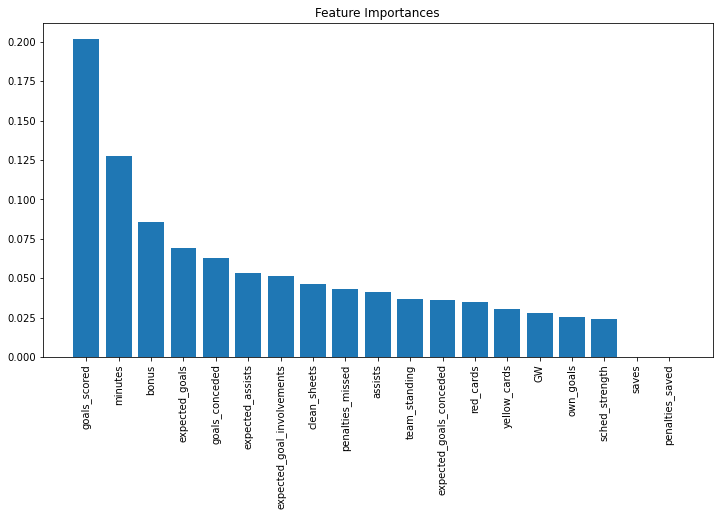

In [58]:
get_feature_importance(fwd_model, X_train_fwd)

### MID Model Performance 

In [48]:
eval_model(mid_model, X_test_mid, y_test_mid)

rmse: 1.0534
R2 score: 0.6420


1. minutes: 0.28707247972488403
2. goals_conceded: 0.12604326009750366
3. assists: 0.06807982176542282
4. clean_sheets: 0.06213514506816864
5. goals_scored: 0.059993475675582886
6. expected_goal_involvements: 0.04385845735669136
7. expected_assists: 0.0416124127805233
8. team_standing: 0.04143229126930237
9. expected_goals: 0.04112934321165085
10. bonus: 0.03804881125688553
11. expected_goals_conceded: 0.03286493942141533
12. GW: 0.0313088484108448
13. yellow_cards: 0.03042866475880146
14. own_goals: 0.02817465551197529
15. sched_strength: 0.02514604479074478
16. red_cards: 0.023226967081427574
17. penalties_missed: 0.019444288685917854
18. penalties_saved: 0.0
19. saves: 0.0


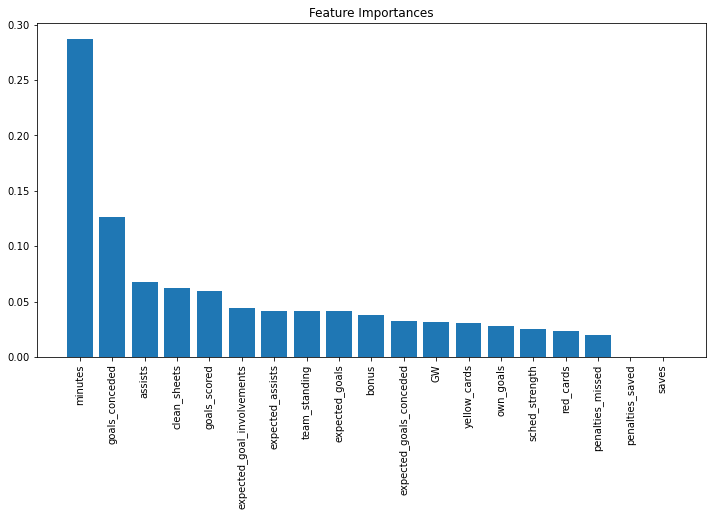

In [59]:
get_feature_importance(mid_model, X_train_mid)

### DEF Model Performance 

In [49]:
eval_model(def_model, X_test_def, y_test_def)

rmse: 0.9623
R2 score: 0.6088


1. minutes: 0.17366909980773926
2. goals_conceded: 0.07548253983259201
3. assists: 0.06614288687705994
4. expected_goals_conceded: 0.06430155038833618
5. team_standing: 0.06277327239513397
6. bonus: 0.05874521657824516
7. expected_assists: 0.0550260953605175
8. GW: 0.054522473365068436
9. expected_goals: 0.052493590861558914
10. clean_sheets: 0.051781464368104935
11. sched_strength: 0.05154264345765114
12. expected_goal_involvements: 0.05002176761627197
13. goals_scored: 0.04795312508940697
14. red_cards: 0.047125719487667084
15. yellow_cards: 0.044809792190790176
16. own_goals: 0.043608710169792175
17. penalties_missed: 0.0
18. penalties_saved: 0.0
19. saves: 0.0


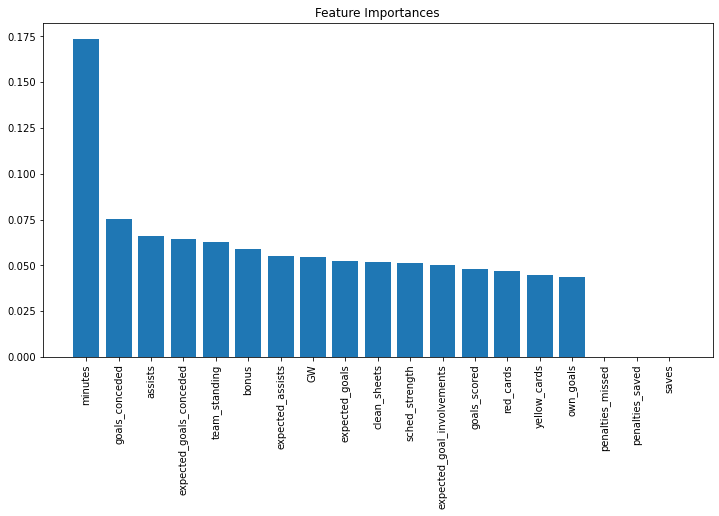

In [60]:
get_feature_importance(def_model, X_train_def)

### GK Model Performance 

In [50]:
eval_model(gk_model, X_test_gk, y_test_gk)

rmse: 0.7305
R2 score: 0.8037


1. minutes: 0.7539758682250977
2. expected_goals: 0.03516390919685364
3. own_goals: 0.022219546139240265
4. saves: 0.02106565795838833
5. penalties_saved: 0.01971108838915825
6. assists: 0.017224490642547607
7. bonus: 0.01460521761327982
8. GW: 0.014155787415802479
9. team_standing: 0.012967127375304699
10. yellow_cards: 0.012915369123220444
11. sched_strength: 0.01280598808079958
12. expected_assists: 0.012773619964718819
13. clean_sheets: 0.012325653806328773
14. goals_conceded: 0.012102914974093437
15. expected_goals_conceded: 0.011274459771811962
16. expected_goal_involvements: 0.009313525632023811
17. red_cards: 0.005399760790169239
18. penalties_missed: 0.0
19. goals_scored: 0.0


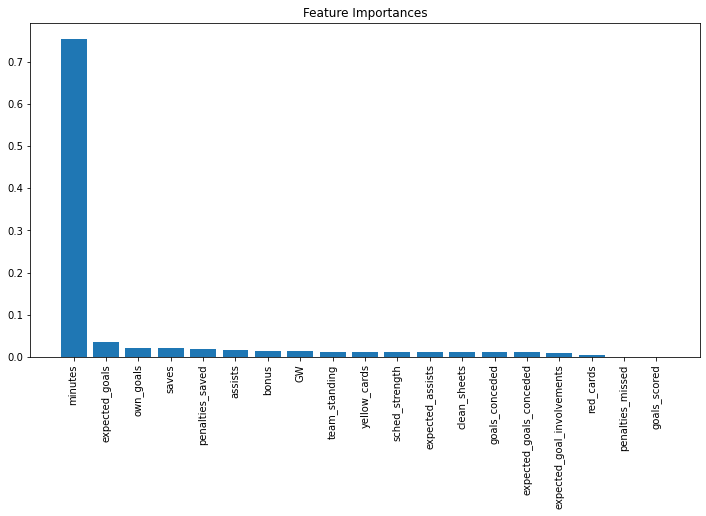

In [61]:
get_feature_importance(gk_model, X_train_gk)